In [30]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow as imshow

## Read Image

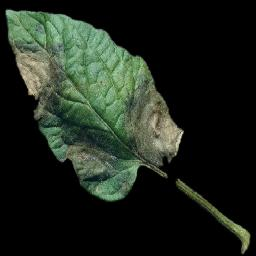

(256, 256, 3)


In [31]:
path = "/content/drive/MyDrive/data/test veins/0ba7d3d8-5c4c-4365-ba0c-69f61e96a36e___RS_Late.B 5312_final_masked.jpg"
img = cv.imread(path)
imshow(img)
print(img.shape)

### Rescale the Image

In [32]:
def image_resize(image, width = None, height = None, inter = cv.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv.resize(image, dim, interpolation = inter)

    return resized

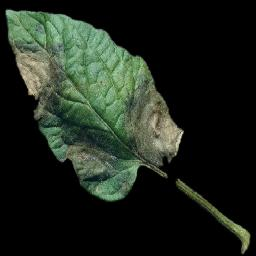

(256, 256, 3)


In [33]:
(height, width) = img.shape[:2]

if height > 800 or width > 800:
  flag = height - width
  if flag >= 0:
    img = image_resize(img, height = 800)
  else:
    img = image_resize(img, height = 800)
imshow(img)
print(img.shape)



# Create a Mask

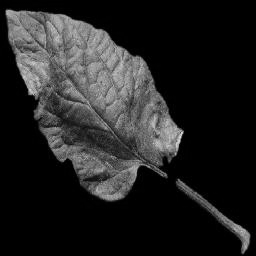

In [34]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
imshow(gray)

In [ ]:
# gray_hist = cv.calcHist([gray], [0], None, [256], [0,256])
# plt.figure()
# plt.title('Gray Histogram')
# plt.xlabel('bits')
# plt.ylabel('No of Pixels')
# plt.plot(gray_hist)
# plt.xlim([0,256])
# plt.ylim([0,5000])
# plt.show()

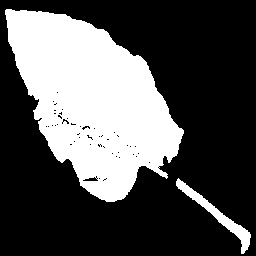

24.0


In [35]:
threshold, thresh = cv.threshold(gray,24,255, cv.THRESH_BINARY)
imshow(thresh)
print(threshold)

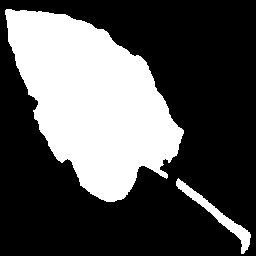

In [36]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
mask = cv.morphologyEx(thresh, cv.MORPH_CLOSE, kernel)
imshow(mask)

# Remove Petiole

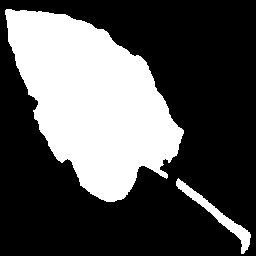

In [38]:
imshow(mask)

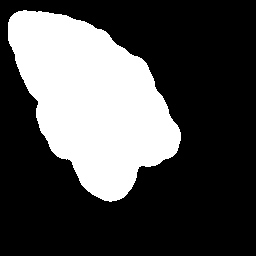

In [37]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(31,31))
mask_2 = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel)
imshow(mask_2)

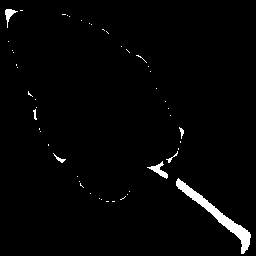

In [39]:
mask_3 = mask - mask_2
imshow(mask_3)

## Area of Largest Island

In [ ]:
# global r
# global c
# global visited
# r,c = mask_3.shape
# graph = np.copy(mask)
# visited = np.full((r,c), False)
# area =0
# max = 0

# def isSafe(row,col,graph):
#   return ( (row<r and row>=0) and (col<c and col>=0) and (not visited[row][col]) and (graph[row][col] != 0) )

# def dfs(row,col,graph, area):
#   rowBoundry = np.array([-1, -1, -1,  0, 0,  1, 1, 1])
#   colBoundry = np.array([-1,  0,  1, -1, 1, -1, 0, 1])

#   visited[row][col] = True
#   for i in range(8):
#     if (isSafe(row + rowBoundry[i], col + colBoundry[i], graph)):
#       area += 1
#       dfs(row + rowBoundry[i], col + colBoundry[i], graph,area)

#   return area



# for i in range(r):
#   for j in range(c):
#     if(not visited[i][j] and graph[i][j]!=0):
#       area = 1
#       area = dfs(i,j,graph,area)
#       if(area > max):
#         max = area

# max

##Connected Component Labeling and Analysis







In [40]:
inp = np.copy(mask_3)
output = cv.connectedComponentsWithStats(inp, 4, cv.CV_32S)
(numLabels, labels, stats, centroids) = output

mask_petiole = np.zeros(inp.shape, dtype="uint8")

In [41]:
maxArea = 0
for i in range(1, numLabels):

  x = stats[i, cv.CC_STAT_LEFT]
  y = stats[i, cv.CC_STAT_TOP]
  w = stats[i, cv.CC_STAT_WIDTH]
  h = stats[i, cv.CC_STAT_HEIGHT]
  area = stats[i, cv.CC_STAT_AREA]
  if maxArea < area:
    maxArea = area
print(maxArea)

895


In [42]:
for i in range(1, numLabels):
  area = stats[i, cv.CC_STAT_AREA]
  if area > maxArea//2:
    print("[INFO] keeping connected component '{}'".format(i))
    componentMask = (labels == i).astype("uint8") * 255
    print(componentMask.shape)
    mask_petiole = cv.bitwise_or(mask_petiole, componentMask)

[INFO] keeping connected component '39'
(256, 256)


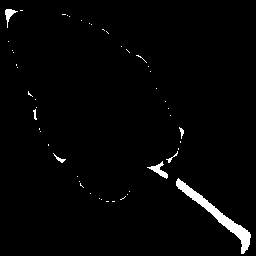

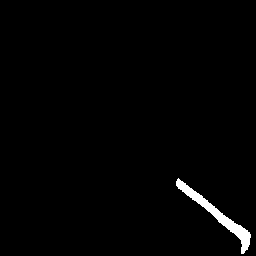

In [43]:
imshow(inp)
imshow(mask_petiole)

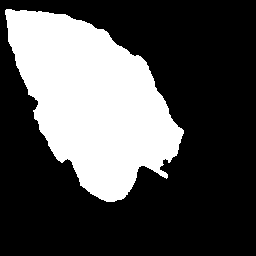

In [44]:
mask =mask - mask_petiole
imshow(mask)

# Extract alpha Channel

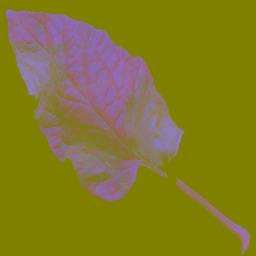

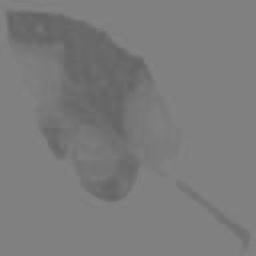

In [45]:
lab = cv.cvtColor(img, cv.COLOR_BGR2LAB)
l,a,b = cv.split(lab)

imshow(lab)
# imshow(l)
imshow(a)
# imshow(b)


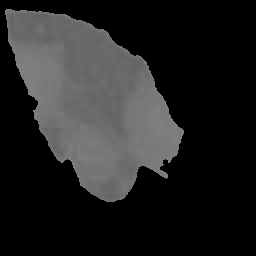

In [46]:
alpha = cv.bitwise_and(a,mask)
# imshow(mask)
# imshow(a)
imshow(alpha)

# Contrast Stretching

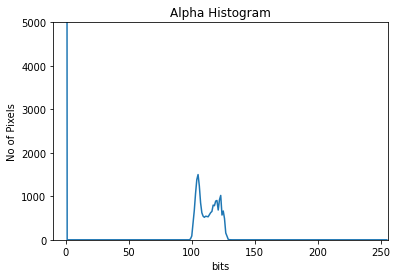

In [47]:
alpha_hist = cv.calcHist([alpha], [0], None, [256], [0,256])
plt.figure()
plt.title('Alpha Histogram')
plt.xlabel('bits')
plt.ylabel('No of Pixels')
plt.plot(alpha_hist)
plt.xlim([-10,256])
plt.ylim([0,5000])
plt.show()

In [ ]:
# a_hist = cv.calcHist([a], [0], None, [256], [0,256])
# plt.figure()
# plt.title('a Histogram')
# plt.xlabel('bits')
# plt.ylabel('No of Pixels')
# plt.plot(a_hist)
# plt.xlim([0,256])
# # plt.ylim([0,10000])
# plt.show()

In [48]:
max= 0 
min = 255 

for i in range(alpha.shape[0]):
  for j in range(alpha.shape[1]):
    if alpha[i][j] == 0:
      continue
    if max < alpha[i][j]:
      max = alpha[i][j]
    if min > alpha[i][j]:
      min = alpha[i][j]

print(min,max)

99 130


In [23]:
alpha.shape

(256, 256)

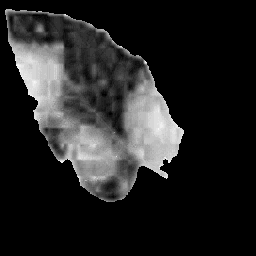

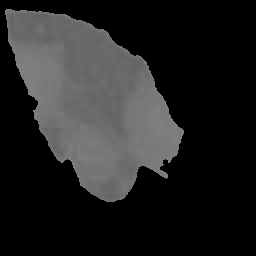

In [49]:
contrast_alpha = np.zeros(alpha.shape, dtype='uint8')
for i in range(alpha.shape[0]):
  for j in range(alpha.shape[1]):
    if alpha[i][j] == 0:
      continue
    contrast_alpha[i][j] = round((alpha[i][j] - min)/(max-min)*255)

imshow(contrast_alpha)
imshow(alpha)

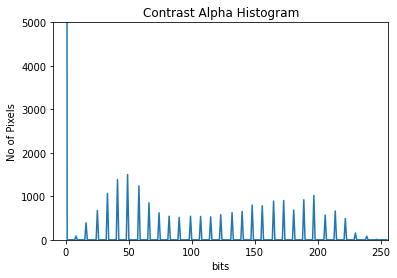

In [50]:
contrast_alpha_hist = cv.calcHist([contrast_alpha], [0], None, [256], [0,256])
plt.figure()
plt.title('Contrast Alpha Histogram')
plt.xlabel('bits')
plt.ylabel('No of Pixels')
plt.plot(contrast_alpha_hist)
plt.xlim([-10,256])
plt.ylim([0,5000])
plt.show()


# Thresholding

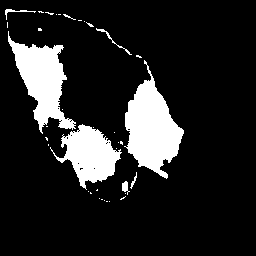

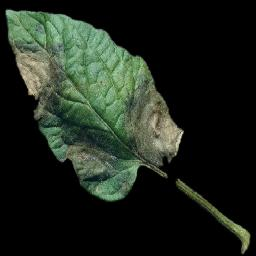

128.0


In [51]:
threshold, thresh1 = cv.threshold(contrast_alpha,128,255, cv.THRESH_BINARY)
imshow(thresh1)
imshow(img)

print(threshold)

In [ ]:
# threshold, thresh2 = cv.threshold(contrast_alpha, 0, 255,cv.THRESH_BINARY | cv.THRESH_OTSU)
# imshow(thresh2)
# imshow(thresh1)
# print(threshold)

#Morphological Operations




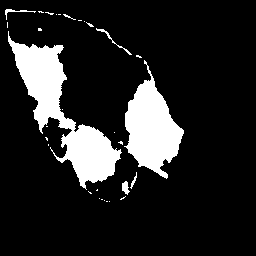

In [52]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
closing = cv.morphologyEx(thresh1, cv.MORPH_CLOSE, kernel)
imshow(closing)

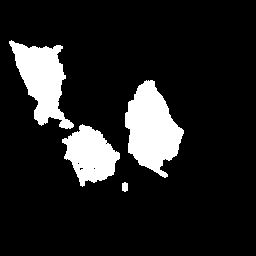

In [53]:
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
opening = cv.morphologyEx(thresh1, cv.MORPH_OPEN, kernel)
imshow(opening)


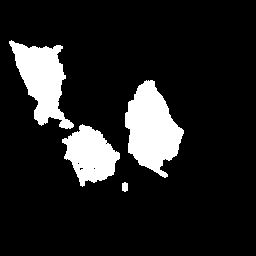

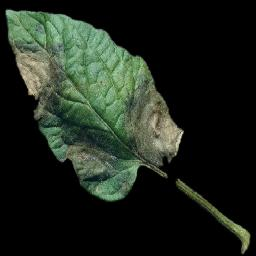

In [54]:
dilation = cv.dilate(opening,kernel,iterations = 1)
out  = cv.bitwise_and(opening,dilation)
imshow(out)
imshow(img)